In [ ]:
!nvidia-smi

In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
df_data = pd.read_csv('multi_label_binarizer_MEISD.csv')

In [3]:
df_data.head()

,Utterances,sentiment_0,sentiment_1,sentiment_2,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_9,intensity_1,intensity_2,intensity_3
0,look around you,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,say hello to your competition,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,five of you will crack under the pressure,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,two of you will be asked to leave,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# For the multilabel classification we use:
columns = ['Utterances', 'sentiment_0', 'sentiment_1', 'sentiment_2']
multi_columns = df_data[columns].copy()

In [5]:
multi_columns

,Utterances,sentiment_0,sentiment_1,sentiment_2
0,look around you,0,0,1
1,say hello to your competition,0,0,1
2,eight of you will switch to an easier specialty,0,0,1
3,five of you will crack under the pressure,0,0,1
4,two of you will be asked to leave,0,0,1
...,...,...,...,...
20012,"oh, that's right, you're a woman and you need ...",1,0,0
20013,i'll try again,1,0,0
20014,"please, pam, reconsider and have a bagel",1,0,0
20015,i have an early lunch,1,0,0


In [6]:
df_data['label'] = multi_columns[['sentiment_0', 'sentiment_1', 'sentiment_2']].idxmax(axis=1)
df_data['label'] = df_data['label'].apply(lambda x: int(x.split('_')[1]))
df_data = df_data[['Utterances', 'label']]
df_data

,Utterances,label
0,look around you,2
1,say hello to your competition,2
2,eight of you will switch to an easier specialty,2
3,five of you will crack under the pressure,2
4,two of you will be asked to leave,2
...,...,...
20012,"oh, that's right, you're a woman and you need ...",0
20013,i'll try again,0
20014,"please, pam, reconsider and have a bagel",0
20015,i have an early lunch,0


In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [8]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

D:\conda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'input_ids': tensor([[  101,  1284,  1132,  5193,   139,  9637,  1942, 22559, 17260,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [9]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [10]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [11]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [12]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [13]:
token_lens = []

for txt in df_data['Utterances']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

C:\Users\Julix\AppData\Local\Temp\ipykernel_13520\453859461.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

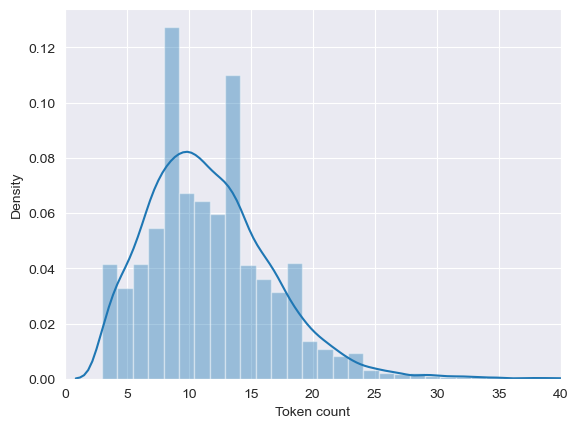

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 40])
plt.xlabel('Token count')

In [15]:
# Hyperparameters
MAX_LEN = 30 #50 #128  # wiekszosc tokenow zdaje sie byc ponizej 40, klasycznie wklada sie tu 256, my przystaniemy na 30
TRAIN_BATCH_SIZE = 32 #8 #16 #32 
#Czasami, przy bardzo niskim tempie uczenia i zbyt dużych batchach, model może wolniej konwergować. Spróbuj zmniejszyć wielkość batcha, np. z 16 do 8.
VALID_BATCH_SIZE = 32 #8 #16 #32
TEST_BATCH_SIZE = 32 #8 #16 #32
EPOCHS = 10
LEARNING_RATE = 5e-6 #1e-05
# Ustawienie bardzo niskiego współczynnika uczenia (np. 1e-05) może spowodować, że model uczy się bardzo wolno, co prowadzi do sytuacji, w której po wielu epokach nie ma znaczącej poprawy w wynikach walidacji.

THRESHOLD = 0.5 # threshold for the sigmoid


In [16]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [17]:
columns = multi_columns.columns
categor_freq = multi_columns[columns[1:]].sum() / multi_columns.shape[0]
categor_freq

sentiment_0    0.186541
sentiment_1    0.221462
sentiment_2    0.591997
dtype: float64

In [18]:
class_distribution = multi_columns[['sentiment_0', 'sentiment_1', 'sentiment_2']].sum()
print(class_distribution)

sentiment_0     3734
sentiment_1     4433
sentiment_2    11850
dtype: int64


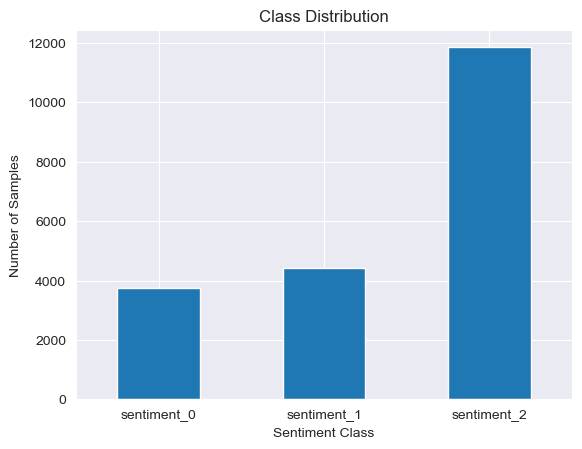

In [19]:
import matplotlib.pyplot as plt

# Wykres rozkładu klas
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

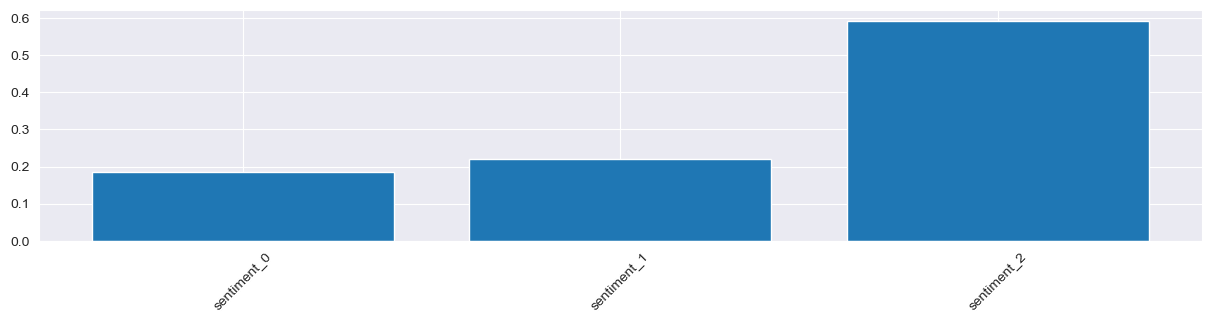

In [20]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 3)
plt.bar(categor_freq.index, categor_freq.values)
_ = plt.xticks(rotation=45)

In [21]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (14011, 2), Test: (3003, 2), Valid: (3003, 2)


In [22]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        # Upewnij się, że etykiety są typu całkowitego (int)
        self.targets = self.df['label'].astype(int).values 
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])  # 'index' jest prawidłowe
        #utterances = " ".join(utterances.split())  # Usuwa niepotrzebne białe znaki

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)  # Zapewnij typ long
        # print(f"Target dtype: {target.dtype}")  # Debugging

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long),  # Zapewnij typ long
            'utterances': utterances
        }


In [23]:
target_list = list(df_data.columns)
target_list = target_list[1:]
target_list

['label']

In [24]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [25]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0
                                                )

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=VALID_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0
                                              )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0
                                               )

In [26]:
data = next(iter(train_data_loader))

In [27]:
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'targets', 'utterances'])
torch.Size([32, 30])
torch.Size([32, 30])
torch.Size([32])


In [28]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)


In [29]:
bert_model.config.hidden_size

768

In [30]:
class BERTSentimentClass(torch.nn.Module):
    def __init__(self):
        super(BERTSentimentClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)
        self.dropout = torch.nn.Dropout(p=0.4) #0.5
        self.linear = torch.nn.Linear(bert_model.config.hidden_size, 3)
        #self.softmax = nn.Softmax(dim=1) #remove for sentiment analysis
        #CrossEntropyLoss automatycznie aplikuje funkcję softmax, więc nie ma potrzeby używać Softmax w modelu.


    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        #pooler_output = self.pooler_output
        dropout_output = self.dropout(output.pooler_output)
        linear_output = self.linear(dropout_output)
        # output = self.softmax(linear_output)
        return linear_output

model = BERTSentimentClass()

# # Freezing BERT layers:
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)


BERTSentimentClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [31]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 30])
torch.Size([32, 30])


In [32]:
class_distribution = multi_columns[['sentiment_0', 'sentiment_1', 'sentiment_2']].sum()
total_samples = sum(class_distribution)
class_weights = [total_samples / count for count in class_distribution]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([5.3607, 4.5155, 1.6892])

In [33]:
def loss_fn(outputs, targets):
    #print(f"Outputs dtype: {outputs.dtype}")  # Debugging
    #print(f"Targets dtype: {targets.dtype}")  # Debugging

    return torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)
#change for sentiment analysis

In [34]:
# TensorBoard writer
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs')

# Harmonogram zmiany learning rate
from torch.optim.lr_scheduler import StepLR

In [35]:
from transformers import AdamW, get_linear_schedule_with_warmup
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
#loss_fn = nn.CrossEntropyLoss().to(device)

D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(ids, mask, token_type_ids)

        # Calculate loss
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Calculate accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Log to TensorBoard and update progress bar
        writer.add_scalar('Loss/train', loss.item(), epoch * len(training_loader) + batch_idx)
        writer.add_scalar('Accuracy/train', correct_predictions / num_samples, epoch * len(training_loader) + batch_idx)
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(batch_loss=loss.item())

    return model, correct_predictions / num_samples, np.mean(losses)


In [37]:
def eval_model(validation_loader, model):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(ids, mask, token_type_ids)

            # Calculate loss before applying argmax
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    writer.add_scalar('Loss/validation', np.mean(losses), epoch)
    writer.add_scalar('Accuracy/validation', correct_predictions / num_samples, epoch)

    return correct_predictions / num_samples, np.mean(losses)


In [38]:
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import io

history = defaultdict(list)
best_accuracy = 0
writer = SummaryWriter(log_dir='logs')

def plot_confusion_matrix(cm, class_names, epoch):
    figure = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix at Epoch {epoch}')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = torch.tensor(np.frombuffer(buf.getvalue(), dtype=np.uint8)).float()
    writer.add_image('Confusion Matrix', image, epoch)

    plt.close(figure)  


In [39]:
from torch.utils.tensorboard import SummaryWriter

In [40]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(val_data_loader, model)
    print(f'Val   loss {val_loss} accuracy {val_acc}')

    # Logowanie strat i dokładności do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc

    all_preds = []  
    all_labels = [] 

    with torch.no_grad():
        for data in val_data_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            preds = torch.argmax(outputs, axis=1).cpu().detach().numpy() 
            labels = targets.cpu().detach().numpy() 

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Oblicz confusion matrix
    # cm = confusion_matrix(all_labels, all_preds)
    # plot_confusion_matrix(cm, class_names=['class0', 'class1', 'class2'], epoch=epoch)
writer.close()

Epoch 1/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 1.0926142645208803 accuracy 0.40318321318963674
Val   loss 1.0279024287741234 accuracy 0.44488844488844487
train_loss=1.0926, val_loss=1.0279, train_acc=0.4032, val_acc=0.4449
Epoch 2/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 1.010083759348142 accuracy 0.46070944258082935
Val   loss 1.0005287515356185 accuracy 0.5114885114885115
train_loss=1.0101, val_loss=1.0005, train_acc=0.4607, val_acc=0.5115
Epoch 3/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.9469644817859615 accuracy 0.5091713653557919
Val   loss 0.9870924004848968 accuracy 0.4955044955044955
train_loss=0.9470, val_loss=0.9871, train_acc=0.5092, val_acc=0.4955
Epoch 4/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.8903472424914304 accuracy 0.550424666333595
Val   loss 1.01033050582764 accuracy 0.48784548784548787
train_loss=0.8903, val_loss=1.0103, train_acc=0.5504, val_acc=0.4878
Epoch 5/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.8449326642027729 accuracy 0.5729783741346085
Val   loss 1.0172829177785427 accuracy 0.47985347985347987
train_loss=0.8449, val_loss=1.0173, train_acc=0.5730, val_acc=0.4799
Epoch 6/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.7930708271727714 accuracy 0.6070230533152523
Val   loss 1.0585252281199111 accuracy 0.5014985014985015
train_loss=0.7931, val_loss=1.0585, train_acc=0.6070, val_acc=0.5015
Epoch 7/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.7598027918300673 accuracy 0.625722646492042
Val   loss 1.0858832952824045 accuracy 0.49983349983349984
train_loss=0.7598, val_loss=1.0859, train_acc=0.6257, val_acc=0.4998
Epoch 8/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.7284615114671454 accuracy 0.6424238098636785
Val   loss 1.1114861876406568 accuracy 0.5038295038295039
train_loss=0.7285, val_loss=1.1115, train_acc=0.6424, val_acc=0.5038
Epoch 9/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.6944633809398842 accuracy 0.6596245806866033
Val   loss 1.126404343133277 accuracy 0.4985014985014985
train_loss=0.6945, val_loss=1.1264, train_acc=0.6596, val_acc=0.4985
Epoch 10/10


  0%|          | 0/438 [00:00<?, ?it/s]

Train loss 0.6897288505073007 accuracy 0.659910070658768
Val   loss 1.1340899385036307 accuracy 0.5024975024975025
train_loss=0.6897, val_loss=1.1341, train_acc=0.6599, val_acc=0.5025
CPU times: total: 10h 16min 41s
Wall time: 1h 53min 53s


# 1. Overfitting:
Opis: Niski train_loss (0.2796) wskazuje na to, że model dobrze dopasowuje się do danych treningowych, ale wysoki val_loss (2.9933) oraz brak poprawy w val_acc (0.0000) sugerują, że model może się przeuczać, czyli dopasowuje się zbyt mocno do danych treningowych i traci zdolność do generalizacji na danych testowych.
Rozwiązanie:
Dodanie technik regularyzacyjnych, jak dropout, L2 regularization.
Wykorzystanie większego zbioru danych.
Zastosowanie wcześniejszego zatrzymania (early stopping), aby przerwać trening, gdy model zaczyna się przeuczać.
# 2. Zbyt niski learning rate:
Opis: Ustawienie bardzo niskiego współczynnika uczenia (np. 1e-05) może spowodować, że model uczy się bardzo wolno, co prowadzi do sytuacji, w której po wielu epokach nie ma znaczącej poprawy w wynikach walidacji.
Rozwiązanie: Spróbuj zwiększyć learning rate np. do 1e-04 i zobacz, czy poprawia to wyniki. Zbyt niski współczynnik uczenia może blokować osiąganie optymalnych wyników.
# 3. Zbyt skomplikowany model:
Opis: Jeśli model jest zbyt złożony w stosunku do dostępnych danych, może to prowadzić do overfittingu. Model nauczy się bardzo dobrze danych treningowych, ale nie będzie w stanie dobrze generalizować.
Rozwiązanie: Możesz spróbować uprościć model (np. mniejsza liczba warstw, mniejsza liczba neuronów) lub zebrać większy zbiór danych, jeśli to możliwe.
# 4. Problemy z danymi:
Opis: Dane walidacyjne mogą zawierać problemy, takie jak błędnie oznaczone próbki, brak różnorodności, lub mogą nie być reprezentatywne dla danych treningowych.
Rozwiązanie: Sprawdź, czy dane walidacyjne są dobrze zrównoważone i poprawnie oznaczone. Ewentualnie przetestuj na innym zbiorze walidacyjnym.
# 5. Złe inicjalizacje wag lub problemy z optymalizacją:
Opis: Wysoki val_loss i brak poprawy w val_acc mogą wskazywać na problemy z optymalizacją. Np. złe inicjalizacje wag lub nieodpowiedni optymalizator mogą powodować, że model nie znajduje optymalnych rozwiązań.
Rozwiązanie: Spróbuj zmienić optymalizator (np. Adam na RMSprop), lub zastosować inne techniki inicjalizacji wag.
# 6. Zbyt zróżnicowane klasy:
Opis: Jeśli Twoje klasy są bardzo niezrównoważone, to model może mieć problem z nauczeniem się klasyfikacji rzadkich klas.
Rozwiązanie: Upewnij się, że klasy są zrównoważone lub użyj metod radzenia sobie z niezrównoważonymi danymi (np. class weights w funkcji straty).


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    return fig

# Tworzenie confusion matrix po ewaluacji
cm = confusion_matrix(all_labels, all_preds)

# Logowanie confusion matrix jako obraz
fig = plot_confusion_matrix(cm, class_names=['class0', 'class1', 'class2'])
writer.add_figure('Confusion matrix', fig, epoch)


In [ ]:
fig